# Calibration

The visibility data obtained by correlation contains systematic
errors.
Many of them shows up as delays, which translate to phase errors in
visibility.
Source of delays include:

* Water vapor in troposphere
* Electron content in Ionosphere
* Instruments
* Clock inaccuracy
* ..
* Thermal noise

Fringe-fitting is a major calibration step to remove the delay and
delay rates in the visibility data so they can be coherencely averaged
to higher signal-to-noise data.

To get a sense on how this works, let's set up our numerical
experiment.
We again need to import the standard python packages.
We also turn fix the noise realizations and put our correlator in a
function.

In [1]:
import numpy as np
from math import pi, ceil
from matplotlib import pyplot as plt

t  = np.linspace(0, 10_000, num=100_000)
n1 = np.random.normal(scale=1, size=100_000)
n2 = np.random.normal(scale=1, size=100_000)

def chunked_FX(s1, s2, n=1000):
    N  = int(ceil(len(s1) / n))
    S1 = np.fft.rfft(np.pad(s1+n1, (0, N*n-len(s1))).reshape(N, n))
    S2 = np.fft.rfft(np.pad(s2+n2, (0, N*n-len(s2))).reshape(N, n))
    return np.conj(S1) * S2

## Adding Delay and Delay Rate

To visualize how the delay and delay rate affect the visibility, we
define $d(t)$ and $r(t)$ and apply them to the signal for the second
station.

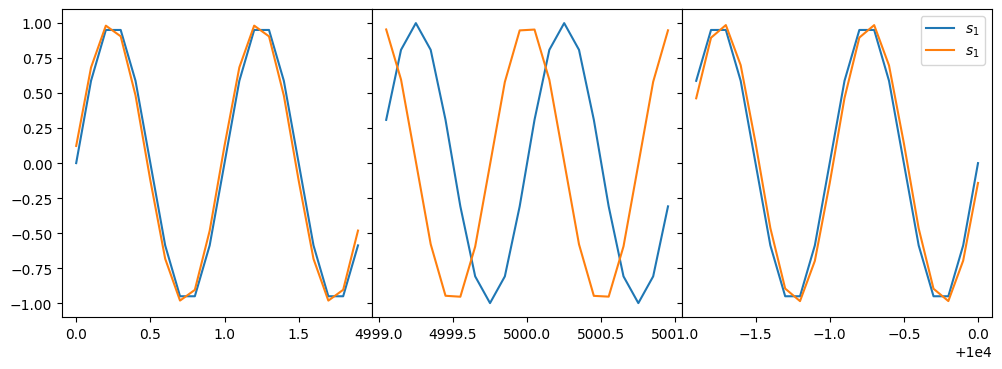

In [2]:
d  = lambda t: 1e+3 * t/len(t) + 1
r  = lambda t: 1e-3 * t/len(t) + 1

s1 = np.sin(2 * pi * t)
s2 = np.sin(2 * pi * r(t) * (t + 0.123 / (2 * pi) * d(t)))

fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey=True, figsize=(12,4))
plt.subplots_adjust(wspace=0)
ax0.plot(t[:20], s1[:20])
ax0.plot(t[:20], s2[:20])
ax1.plot(t[50_000-10:50_000+10], s1[50_000-10:50_000+10])
ax1.plot(t[50_000-10:50_000+10], s2[50_000-10:50_000+10])
ax2.plot(t[-20:], s1[-20:], label=r'$s_1$')
ax2.plot(t[-20:], s2[-20:], label=r'$s_1$')
ax2.legend()

## Correlating the Signals

Using `chunked_FX()`, we can compute the visibility.

It has a "spectral" line at `freqnecy == 100` because the signal is
still monochromatic.

Text(0, 0.5, 'time')

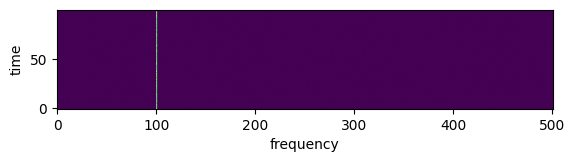

In [3]:
FX = chunked_FX(s1, s2)

plt.imshow(abs(FX), origin='lower')
plt.xlabel('frequency')
plt.ylabel('time')

Focusing in our band at $\nu = 100$, it is easy to see the phase drift
away from a stable value.

Text(0.5, 0, 'time')

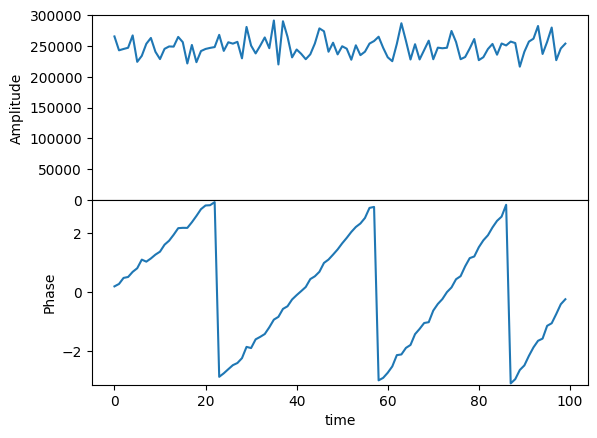

In [4]:
vis = FX[:,100]

fig, (ax0, ax1) = plt.subplots(2,1, sharex=True)
plt.subplots_adjust(hspace=0)

ax0.plot(abs(vis))
ax0.set_ylabel('Amplitude')
ax0.set_ylim(0, 300_000)

ax1.plot(np.angle(vis))
ax1.set_ylabel('Phase')
ax1.set_ylim(-pi, pi)
ax1.set_xlabel('time')

This phase drift affects coherence average.
When we average over long time scale, the coherencely averaged
amplitude drops, as shown in the following figure.
This is the reason incoherence averages are used sometimes.

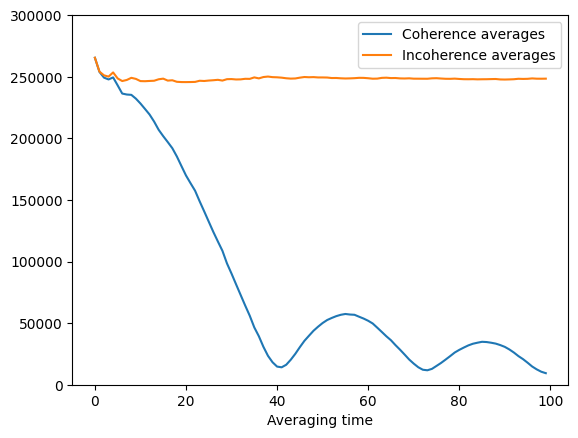

In [5]:
coh_avgs   = [abs(np.mean(vis[:i])) for i in range(1, 100+1)]
incoh_avgs = [np.mean(abs(vis[:i])) for i in range(1, 100+1)]

plt.plot(coh_avgs,   label='Coherence averages')
plt.plot(incoh_avgs, label='Incoherence averages')
plt.ylim(0, 300_000)
plt.xlabel('Averaging time')
plt.legend()

## Fringe-Fitting

The idea behind fringe-fitting is that we can expand the phase of an
arriving signal in terms of frequency and phase
\begin{align}
  \Delta\phi(\nu,t) \approx \phi_0 + \frac{\partial\phi}{\partial\nu}\Delta\nu + \frac{\partial\phi}{\partial t}\Delta t,
\end{align}
where $\phi_0$ is the phase error,
$\partial\phi/\partial\nu$ is the delay, and
$\partial\phi/\partial t$ is the (delay) rate.
Any process that estimate the delay and rate is considered
fringe-fitting.

For phase in the visibility, the idea is the same,
\begin{align}
  \Delta\phi_{12}(\nu, t)
  = \phi_{1,0} - \phi_{2,0}
  + (\frac{\partial\phi_1}{\partial\nu} - \frac{\partial\phi_2}{\partial\nu})\Delta\nu
  + (\frac{\partial\phi_1}{\partial t } - \frac{\partial\phi_2}{\partial t })\Delta t,
\end{align}

HOPS performs fringe fitting for each baseline independently, so
effectively it is fitting for the terms
$(\partial\phi_1/\partial\nu - \partial\phi_2/\partial\nu)$ and
$(\partial\phi_1/\partial t  - \partial\phi_2/\partial t )$.

In principle, we may use $\chi^2$-fitting to fit a straight line to
the phase, and de-rotate the visibility using such a fit.
In practice, however, because phase is a circular (or directional)
quantity, it is non-trivial to write a $\chi^2$-fitting method that
can work for arbitrary number of phase wraps.

Fortunately, Fourier transform has an interesting property that is
useful for fringe fitting.
Consider a function $f(t)$ and its Fourier transform $\hat{F}_\nu$.
When shifted by $t_0$ in time, the phase of the Fourier coefficient is
subjected to a linear rotation.
This can be easily proved.
Let $g(t) = f(t - t_0)$ and $\hat{G}_\nu$ be its Fourier transform,
\begin{align}
  \hat{G}_\nu
  &= \int g(t) e^{-2\pi\nu t} dt \\
  &= \int f(t - t_0) e^{-2\pi\nu t} dt \\
  &= \int f(t') e^{-2\pi\nu (t' + t_0)} dt'
   = \hat{F}_\nu e^{-2\pi\nu t_0}.
\end{align}
Therefore, it is possible to identify the linear part of phase drift
by solving for a shift in the Fourier transform of the visibility.

Here, we will remove the rate in our synthetic data.
We first perform Fourier transform of our visibility.
The `fftshift()` is not essential---it simply help plotting.

0.03


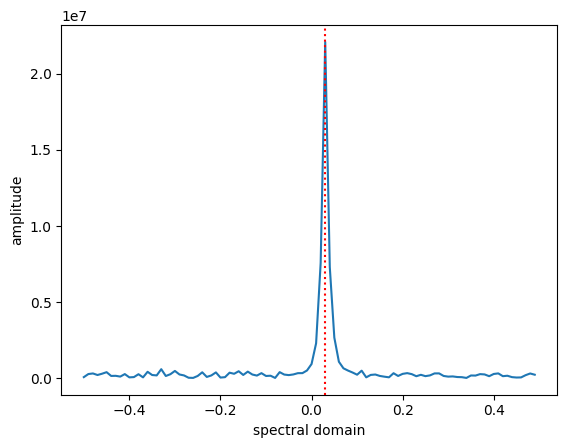

In [6]:
Vis = np.fft.fftshift(np.fft.fft(vis))
R   = np.fft.fftshift(np.fft.fftfreq(100))
Rp  = R[np.argmax(abs(Vis))] # location of the peak in `Vis`

print(Rp)

plt.plot(R, abs(Vis))
plt.xlabel('spectral domain')
plt.ylabel('amplitude')
plt.axvline(Rp, color='r', linestyle=':')

With `Rp`, we can derotate the phase in the visiblity:

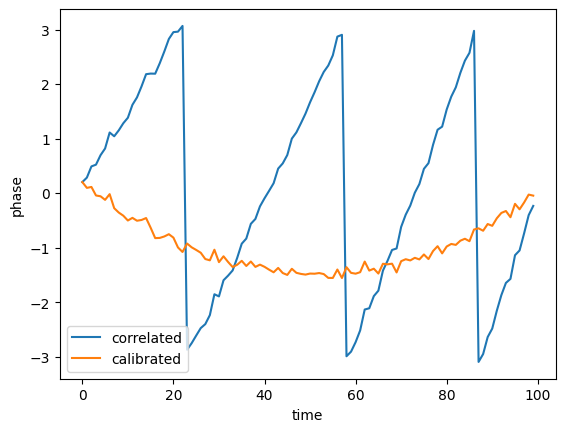

In [7]:
viscal = vis * np.exp(-2j * pi * Rp * np.arange(len(vis)))

plt.plot(np.angle(vis),    label='correlated')
plt.plot(np.angle(viscal), label='calibrated')
plt.xlabel('time')
plt.ylabel('phase')
plt.legend()

Without the linear trend, we can perform coherence average for much longer time.

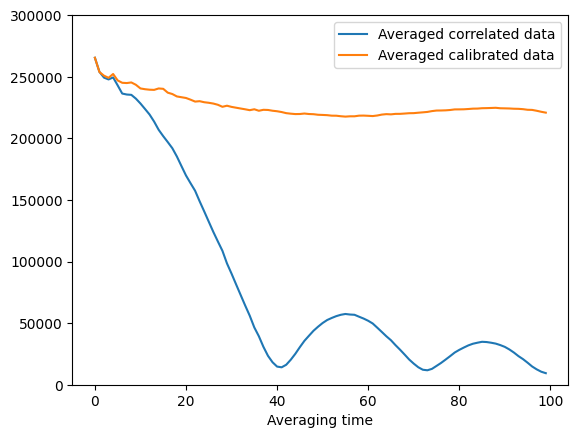

In [8]:
vis_avgs    = [abs(np.mean(vis[:i]))    for i in range(1, 100+1)]
viscal_avgs = [abs(np.mean(viscal[:i])) for i in range(1, 100+1)]

plt.plot(vis_avgs,    label='Averaged correlated data')
plt.plot(viscal_avgs, label='Averaged calibrated data')
plt.ylim(0, 300_000)
plt.xlabel('Averaging time')
plt.legend()